# Testing Multifidelity against Hartmann Function (July 2024)

These plots will be needed for the write-up.

## i) Non-batch Case

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns

import torch

from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP, SingleTaskGP
from botorch.posteriors.gpytorch import scalarize_posterior
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.knowledge_gradient import qMultiFidelityKnowledgeGradient
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.acquisition.max_value_entropy_search import qMultiFidelityMaxValueEntropy
from botorch.acquisition import PosteriorMean 
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch import test_functions
import numpy as np
from scipy.spatial.distance import cdist
from botorch import fit_gpytorch_mll
torch.set_printoptions(precision=12, sci_mode=False)
import copy
import math
import matplotlib.pyplot as plt
import random
import time
import pickle
import os

import warnings
warnings.filterwarnings("ignore")


In [2]:
def setUpSampleSpace(spaceSize=200, var = 1, lf_cost=0.1):
      lf_cost = torch.tensor([lf_cost])
      problem = test_functions.AugmentedHartmann(negate=True)
      Xpr_before = np.random.rand(spaceSize, 6)
      Xpr = [np.append(i, [1.0]) for i in Xpr_before ]
      Xpr_tensor = torch.tensor(Xpr)
      output = problem(X=Xpr_tensor).unsqueeze(-1)
      X_total_hf = torch.cat((Xpr_tensor, output), dim=1)

      domain = []
      for index, hf in enumerate(X_total_hf):
            domain.append(hf)
            value = torch.cat((lf_cost, (hf[-1] + random.gauss(0, var)).reshape(1)), dim=0)
            domain.append(torch.cat((Xpr_tensor[index][0:6], value), dim=0))
      
      domain = torch.stack(domain)
      timestr = time.strftime("%Y%m%d-%H%M%S")
      fileName = 'HartmannSampleSpaces/'+timestr + '.csv'
      os.makedirs('HartmannSampleSpaces/', exist_ok=True)
      np.savetxt(fileName, domain, delimiter=',')

      return fileName

def setUpInitialData(sampleSpaceName, initialSize=10, predefined_indices = None, sf=False, file=True):
      # The file argument is telling us whether we expect the sampleSpaceName to be a file or the actual domain is already in memory.
      # The predefined_indices argument us used in the batch case across multiple search-algorithms where we want 
      #  each element in the batch to have the same intitial set up so that we can compare the averages fairly.
      sampleSpace = np.loadtxt(sampleSpaceName, delimiter=',') if file else sampleSpaceName
      if predefined_indices is None:
            bad_range = True
            top_size = len(sampleSpace) //20
            hf_points = sampleSpace[np.where(sampleSpace[:, -2]==1)]
            top_5_percent = hf_points[hf_points[:, -1].argsort()[::-1]][0:top_size, 0]

            while bad_range:
                  bad_range = False
                  sampleSpace_hf = sampleSpace[np.where(sampleSpace[:, -2]==1)]
                  size = len(sampleSpace_hf)
                  index_store = random.sample(range(size), initialSize)
                  #This gets the high fidelity and low fidelity points in pairs if we're doing MF.
                  sampleSpace, index_store = (sampleSpace_hf, index_store) if sf else (sampleSpace, [2 * x  for x in  index_store] + [1 + 2 * x for x in index_store])
                  fidelity_history = sampleSpace[index_store, -2]
                  train_X = sampleSpace[index_store, :-1]
                  train_obj = sampleSpace[index_store, -1:]

                  #Do not have an intitial sample that includes the top 5% of points                  
                  for row in train_X:
                       if row[0] in top_5_percent:
                            bad_range=True
                            break
                  
            return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, index_store, fidelity_history.flatten().tolist()
      else:
            fidelity_history = sampleSpace[predefined_indices, 1]
            train_X = sampleSpace[predefined_indices, :-1]
            train_obj = sampleSpace[predefined_indices, -1:]
            return torch.tensor(train_X), torch.tensor(train_obj), sampleSpace, predefined_indices, fidelity_history.flatten().tolist()

def generate_batch_indices(sampleSpaceName, initialSize=5, batch_size=5):
      batch_index_store = []
      for batch_no in range(batch_size):
          _, _, _, index_store,_ = setUpInitialData(sampleSpaceName, initialSize, file=False)
          batch_index_store.append(index_store)
      return batch_index_store
     
     
# Required when we want to ensure that the sf has the same hf points in its intitial sampel as the mf case.
def convertMFDatatoSFData(sampleSpace, indexStore):
      sampleSpace_hf = sampleSpace[np.where(sampleSpace[:, -2]==1)]
      index_store = [x // 2 for x in indexStore if x % 2 == 0]
      return torch.tensor(sampleSpace_hf[index_store, : -1]), torch.tensor(sampleSpace_hf[index_store, -1:]), sampleSpace_hf, index_store, sampleSpace[index_store, 1].flatten().tolist()
    

def save_dictionary(dictionary, batch=False, root='HartmannSearchDictionaries'):
      os.makedirs(root, exist_ok=True)
      timestr = time.strftime("%Y%m%d-%H%M%S")
      fileName = root + '/' + 'Batch_' + timestr if batch else root + '/' + timestr
      with open(fileName, 'wb') as handle:
         pickle.dump(dictionary, handle)
      return fileName

def load_dictionary(file):
    with open(file, 'rb') as inp:
      output = pickle.load(inp)
      return output

def save_image(fig, root='Images/'):
      os.makedirs(root, exist_ok=True)
      timestr = time.strftime("%Y%m%d-%H%M%S")
      fig.savefig(f'{root}/{timestr}')
            
def create_correlation_dict(no_points, corr_parameters):
    range_100 = np.random.rand(no_points, 6)
    problem = test_functions.AugmentedHartmann(negate=True)
    high_fid = problem(torch.cat((torch.tensor(range_100), torch.ones(no_points).unsqueeze(-1)), dim=1))
    corr_dict = {'base': range_100, '1': high_fid}
    gaussian_noise = np.array([random.gauss(0, 50) for x in range(0, no_points) ])
    for n in corr_parameters:
        low_fid = np.add(high_fid, 1/n * gaussian_noise)
        correlation = np.corrcoef(high_fid, low_fid)[0,1]
        corr_dict[str(correlation)] = low_fid
    return corr_dict

def compute_correlation(domain):
      hf_points = np.where(domain[:, -2] == 1)
      lf_points = np.where(domain[:, -2] != 1)
      return np.corrcoef(domain[hf_points, -1], domain[lf_points, -1])[0,1]



In [3]:
def runMes(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    candidate_set = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(10000, 1)
    target_fidelities = {6: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={6: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    acquisition = qMultiFidelityMaxValueEntropy(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            candidate_set=candidate_set,
        )
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]))
    return acquisitionScores

In [4]:
def runKG(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr = torch.tensor(Xrpr)
    bounds = torch.tensor([[0.0] * Xrpr.shape[1], [1.0] * Xrpr.shape[1]])
    target_fidelities = {1: 1.0}
            
    cost_model = AffineFidelityCostModel(fidelity_weights={1: 1.0}, fixed_cost=1.0)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=Xrpr.shape[1],
        columns=[Xrpr.shape[1]-1],
        values=[1],
    )                
    _, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:,:-1],
        q=1,
        num_restarts= 2,
        raw_samples=4
    )
    acquisition = qMultiFidelityKnowledgeGradient(
            model=model,
            cost_aware_utility=cost_aware_utility,
            project=lambda x: project_to_target_fidelity(X=x, target_fidelities=target_fidelities),
            current_value=current_value,
            num_fantasies= 5
        )
    acquisitionScores =  acquisition.evaluate(Xrpr.reshape(-1,1, Xrpr.shape[1]), bounds=bounds).detach()
    return acquisitionScores

In [5]:
def runEI(model, Xrpr, previous_evaluations, train_x_past=None):
    Xrpr = torch.tensor(Xrpr)
    acquisition = ExpectedImprovement(
            model=model,
            best_f= max(previous_evaluations)
        )
    
    acquisitionScores =  acquisition.forward(Xrpr.reshape(-1,1, Xrpr.shape[1]) ).detach()
    return acquisitionScores

In [6]:
def runTVR(model, Xrpr, previous_evaluations=None, train_x_past=None):
    Xrpr_hf = Xrpr[np.where(Xrpr[:, -1]==1)]
    # indices = np.where(train_x_past[:, 1] == 1)

    acquisition_scores = runEI(model, Xrpr_hf, previous_evaluations)
    max_hf_ind = acquisition_scores.argmax()

    index_in_xrpr = Xrpr.tolist().index(Xrpr_hf[max_hf_ind].tolist())
    Xrpr = torch.tensor(Xrpr)

    posterior = model.posterior(Xrpr)

    pcov = posterior.distribution.covariance_matrix
    p_var = posterior.variance
    hf_max_cov = pcov[index_in_xrpr]
    hf_max_var = hf_max_cov[index_in_xrpr]
    cost = Xrpr[:, -1]
    
    return hf_max_cov ** 2 / (p_var.reshape(-1) * hf_max_var * cost)   
    
# This approach transforms the fidelity column to be as described in the paper, i.e. [1] -> [0] and [0.1] -> 1
# We do this transformation repeatedly as we wish to keep the data as it is, since the output from these searches 
# are required to stick to a specific format so that the graphing functionality knows how to deal with it.
def runTVR_mod(model, Xrpr, previous_evaluations=None, train_x_past=None):
    X_rpr_transf = copy.deepcopy(Xrpr)

    for row in range(len(X_rpr_transf)):
        X_rpr_transf[row][-1] = 1 if X_rpr_transf[row][-1] != 1 else 0

    #Get hf data-points. 
    Xrpr_hf = X_rpr_transf[np.where(X_rpr_transf[:, -1]==0)]

    acquisition_scores = runEI(model, Xrpr_hf, previous_evaluations)
    max_hf_ind = acquisition_scores.argmax()

    index_in_xrpr = X_rpr_transf.tolist().index(Xrpr_hf[max_hf_ind].tolist())
    Xrpr_transf = torch.tensor(X_rpr_transf)

    posterior = model.posterior(Xrpr_transf)

    pcov = posterior.distribution.covariance_matrix
    p_var = posterior.variance
    hf_max_cov = pcov[index_in_xrpr]
    hf_max_var = hf_max_cov[index_in_xrpr]
    cost = Xrpr[:, -1]
    return  hf_max_cov ** 2 / (p_var.reshape(-1) * hf_max_var * torch.tensor(cost))   

In [7]:
def runCustom(model, Xrpr, previous_evaluations=None, train_x_past=None):
    mes = runMes(model, Xrpr, previous_evaluations, train_x_past)
    normalized_mes= mes / torch.sqrt(torch.sum(mes**2))
    tvr = runTVR(model, Xrpr, previous_evaluations, train_x_past)
    normalized_tvr = tvr / torch.sqrt(torch.sum(tvr**2))
    return normalized_mes + normalized_tvr

In [8]:
def optimiseAcquisitionFunction(sortedAcqusitionScores, domain, trainingData, index_store):
    # X_detached = trainingData.detach().numpy()
    # def checkFunction(candidate, set):
    #     for x in set:
    #         if np.array_equal(candidate[:-1], x):
    #             return True
    #     return False
    def checkIndexNotAlreadyEvaluated(candidate, set):
        return candidate in set
    
    for i in range(domain.shape[0]):
        if not checkIndexNotAlreadyEvaluated(sortedAcqusitionScores[i].item(), index_store):
            index_store.append(sortedAcqusitionScores[i].item())
            return domain[sortedAcqusitionScores[i], 0:-2], domain[sortedAcqusitionScores[i], -2], domain[sortedAcqusitionScores[i], -1]
            # , sortedAcqusitionScores[i]

In [9]:
def run_entire_cycle(train_x_full, 
                     train_obj, 
                     domain, 
                     fidelity_history, 
                     index_store, 
                     func,
                     sf=False, 
                     no_of_iterations=100000, 
                     allocated_budget=100000
                     ):
    train_x_full = copy.deepcopy(train_x_full)
    train_obj = copy.deepcopy(train_obj)
    fidelity_history = copy.deepcopy(fidelity_history)
    index_store = copy.deepcopy(index_store)
    
    domain_X_only = domain[:, 0:-1]
    budget_sum = sum(fidelity_history)
    iteration_counter = 0
    while budget_sum  <= allocated_budget - 1 and iteration_counter < no_of_iterations: 
        # The - 1 important in the budget (as well as the equal) as the check happens at the start and we only really care about high-fidelity points.
        # Consider a budget of 40, and when we hit the sum at 39. We would want the subsequent step to be the last
        # as at most we can add 1. If we instead only add 0.5, you could argue that stopping at 39.5 is premature
        # and we could go another step since it's possible to get another low-fidelity point, but this does not interest us.
        # It's the high-fidelity points we care about and then that would exceed the budget.
        model = SingleTaskGP(train_x_full, train_obj) if sf else SingleTaskMultiFidelityGP(train_x_full, train_obj, data_fidelity=6 )
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)  
        acquisitionScores = func(model=model, Xrpr=domain_X_only, previous_evaluations = train_obj, train_x_past=train_x_full )
        sorted_acqusition_scores = acquisitionScores.argsort(descending=True)
        top_candidate, fidelity, evaluation = optimiseAcquisitionFunction(sorted_acqusition_scores, domain, train_x_full, index_store)
        fidelity_history.append(fidelity)
        np.append(top_candidate, fidelity)
        train_x_full = torch.cat([train_x_full, torch.tensor(np.append(top_candidate, fidelity)).unsqueeze(0)])
        train_obj = torch.cat([train_obj, torch.tensor([evaluation]).unsqueeze(-1)])
        iteration_counter+=1
        budget_sum += fidelity
        
    cumulative_cost = [fidelity_history[0]]
    for i in range(len(fidelity_history) - 1):
        cumulative_cost.append(cumulative_cost[-1] + fidelity_history[i+1])
    return train_x_full, train_obj, cumulative_cost, index_store

In [72]:
file = setUpSampleSpace(500, var=0.3, lf_cost=0.1)
print(file)

HartmannSampleSpaces/20240704-211342.csv


In [73]:
# N_ITER = 30
N_INIT = 5
ALLOCATED_BUDGET = 50
# fileName = 'SampleSpaces/20240606-114441.csv'
# fileName = 'SampleSpaces/20240625-120942.csv'
fileName = file

train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(fileName, N_INIT)
print(index_store)
print(compute_correlation(domain=domain))

[658, 280, 680, 644, 314, 659, 281, 681, 645, 315]
0.8218351447517099


In [74]:
train_x_full_tvr, train_obj_tvr, cumulative_cost_tvr, index_store_tvr = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    func=runTVR,
    allocated_budget=ALLOCATED_BUDGET,
    )

train_x_full_mes, train_obj_mes, cumulative_cost_mes, index_store_mes = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runMes,
    allocated_budget=ALLOCATED_BUDGET
    )

train_x_full_custom, train_obj_custom, cumulative_cost_custom, index_store_custom = run_entire_cycle(
    train_x_full, 
    train_obj, 
    domain, 
    fidelity_history,
    index_store,
    runCustom,
    allocated_budget=ALLOCATED_BUDGET
    )


# The single fidelity case requires different initial data. For example, the initial sample must be all HF and the domain is all HF.
# The fidelity history is less important here as we know all chosen points will be HF, but we keep them so that we can reuse the same function.
train_x_full_sf, train_obj_sf, domain_sf, index_store_sf, fidelity_history_sf = convertMFDatatoSFData(domain, index_store)
train_x_full_ei, train_obj_ei, cumulative_cost_ei, index_store_ei= run_entire_cycle(
    train_x_full_sf, 
    train_obj_sf, 
    domain_sf,
    fidelity_history_sf,
    index_store_sf,
    runEI,
    sf=True,
    allocated_budget=ALLOCATED_BUDGET)

In [75]:
modelDict = {
    "MF-TVR": (train_x_full_tvr, train_obj_tvr, cumulative_cost_tvr),
    "MF-MES": (train_x_full_mes, train_obj_mes, cumulative_cost_mes),
    "MF-Custom": (train_x_full_custom, train_obj_custom, cumulative_cost_custom),
    "SF-EI" : (train_x_full_ei, train_obj_ei, cumulative_cost_ei),
             }
dict_filename = save_dictionary(modelDict, batch=False)    

In [19]:
# modelDict = load_dictionary('HartmannSearchDictionaries/20240703-211837')

In [10]:
# Plot the fidelities.
import matplotlib.pyplot as plt

def plot_fidelities(samples, targets, cumulated_cost, title, total_domain, colours=['red', 'blue', 'green']):
    max_in_space= np.max(total_domain[np.where(total_domain[:, -2] == 1.0)])
    samples = samples.detach().numpy()
    targets = targets.detach().numpy()
    fidelities = list(dict.fromkeys(np.round(samples[:, -1], 3)))
    fidelities.sort(reverse=True)
    for fidelity in fidelities:
        fidelity_target=[]
        fidelity_iteration=[]
        for i in range(len(cumulated_cost)):
            if (round(samples[i, -1],3) == fidelity):
                fidelity_target.append(targets[i])
                fidelity_iteration.append(cumulated_cost[i])
        # maximum_target.append(max(df_total[df_total['fidelity']==fidelity]['target']))
        legend_text = f'Fidelity: {round(fidelity, 3)}'
        plt.scatter(fidelity_iteration, fidelity_target, label=legend_text, color=colours[fidelities.index(fidelity)])
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for Best Fidelity')
    plt.legend(loc="lower right")
    plt.xlabel("Accumulated Cost")
    plt.ylabel("Evaluation")
    plt.ylim([min(targets)-1, max_in_space +1])
    plt.title(title)

In [35]:
N_INIT = 5
ALLOCATED_BUDGET = 50
modelDict = load_dictionary('HartmannSearchDictionaries/20240705-141259')
domain = np.loadtxt('HartmannSampleSpaces/20240705-135132.csv', delimiter=',')

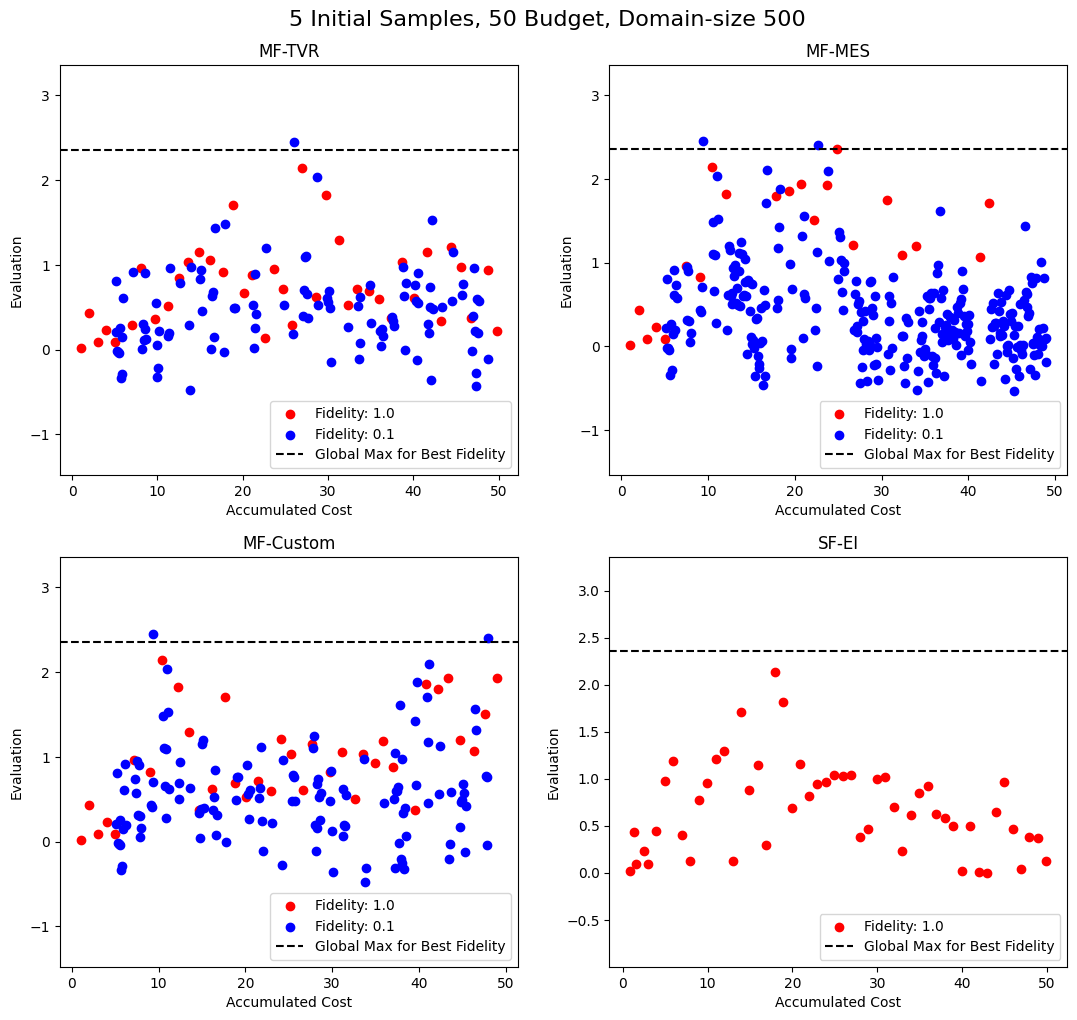

In [36]:
def plot_fidelities_for_dict(dictionary, dictionary_domain, allocated_budget=50, number_init=5):
    figure = plt.figure(figsize=(13,11))
    no_of_rows = math.ceil(len(dictionary.keys())/2)
    for id, key in enumerate(dictionary):
        plt.subplot(no_of_rows, 2, id + 1)
        plot_fidelities(dictionary[key][0], dictionary[key][1], dictionary[key][2], f'{key}', dictionary_domain)
    plt.suptitle(f'{number_init} Initial Samples, {allocated_budget} Budget, Domain-size {int(len(dictionary_domain)/2)}',  size=16)
    plt.subplots_adjust(top=0.93)
    plt.show()

plot_fidelities_for_dict(modelDict, domain)


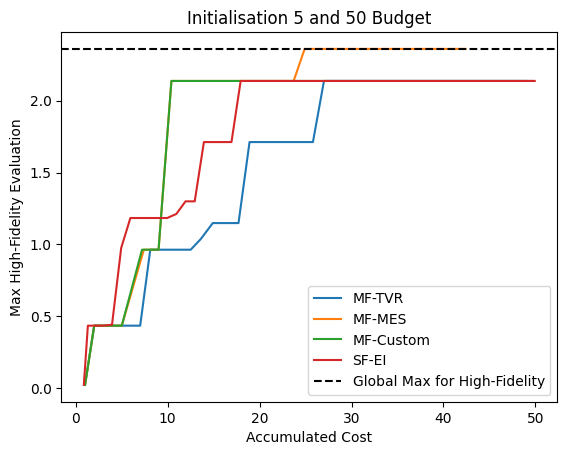

In [37]:
# Here we plot the maximum high-fidelity target reached so far with a given cost. 
def plot_cost(domain, dictionary, title): 
    max_in_space= np.max(domain[np.where(domain[:, -2] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        cumulative_cost_array = np.array(cumulative_cost)
        hf_indices = np.where(train_x_full[:, -1]==1.0)
        high_fidelity_obj = train_obj[np.where(train_x_full[:, -1]==1.0)].detach().numpy()
        accum_target = []
        for i in range(len(high_fidelity_obj)):
            accum_target.append(max(high_fidelity_obj[0:i+1]))

        plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=search_alg)    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Evaluation')
    plt.title(title)
    plt.legend()

plot_cost(domain, modelDict,f'Initialisation {N_INIT} and {ALLOCATED_BUDGET} Budget' )

In [26]:
def plot_histogram(domain):
    high_fidelity = domain[np.where(domain[:, -2]==1.0)]
    low_fidelity = domain[np.where(domain[:, -2]!= 1.0)]
    correlation = np.corrcoef(high_fidelity[:, -1], low_fidelity[:, -1])[0,1]

    plt.hist(high_fidelity[:, -1], label='High-fidelity Data', bins=10, alpha=0.5)
    plt.hist(low_fidelity[:, -1], label='Low-fidelity Data', bins=10, alpha=0.5)
    plt.title('Distribution of Evaluations')
    plt.xlabel('f(x)')
    plt.ylabel('Frequency')
    plt.legend()

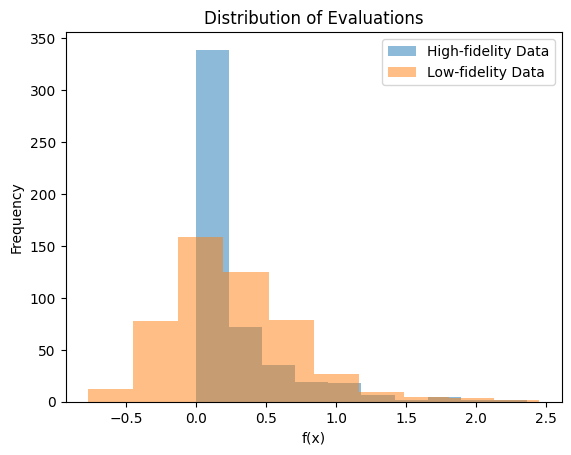

In [28]:
domain_single= np.loadtxt('HartmannSampleSpaces/20240705-135132.csv', delimiter=',')
plot_histogram(domain_single)

## ii) Batches and Average
Now we consider multiple runs and average the results.

In [11]:
# Adding in batch functionality
def run_entire_cycle_batch(experiments, 
                           domain_input, 
                           initial_sample_size, 
                           func, 
                           no_of_iterations=10000, 
                           allocated_budget=10000,
                           predefined_indices_batch=None, 
                           sf=False, 
                           file = True):
    train_x_full_batch = []
    train_obj_batch = []
    cumulative_cost_batch = [] 
    index_store_batch = []
    for j in range(experiments):
        predefined_indices = None if predefined_indices_batch is None else predefined_indices_batch[j]
        train_x_full, train_obj, domain, index_store, fidelity_history = setUpInitialData(domain_input, 
                                                                                        initial_sample_size,
                                                                                        predefined_indices=predefined_indices, 
                                                                                           sf=sf, 
                                                                                           file=file)
        train_x_full, train_obj, cumulative_cost, index_store = run_entire_cycle(
            train_x_full, 
            train_obj, 
            domain, 
            fidelity_history, 
            index_store, 
            func,
            sf=sf,
            no_of_iterations=no_of_iterations,
            allocated_budget=allocated_budget)       
  
        train_x_full_batch.append(train_x_full)
        train_obj_batch.append(train_obj)
        cumulative_cost_batch.append(cumulative_cost)
        index_store_batch.append(index_store)
    return train_x_full_batch, train_obj_batch, cumulative_cost_batch, index_store_batch

In [37]:
# N_ITER_BATCH = 30
N_EXP_BATCH = 5
INIT_SAMPLE_SIZE_BATCH=5
ALLOCATED_BUDGET_BATCH = 50
# fileName = 'SampleSpaces/20240626-193548.csv'
# domain = np.loadtxt(fileName, delimiter=',')
# fileName=file
# domain = np.loadtxt(fileName, delimiter=',')

predefined_indices = generate_batch_indices(domain, INIT_SAMPLE_SIZE_BATCH, N_EXP_BATCH)
    
# rand_sample = [random.sample(range(int(len(domain)/2)), INIT_SAMPLE_SIZE_BATCH) for j in range(N_EXP_BATCH)]
# predefined_indices = [[2 * x  for x in  rand_sample[i]] + [1 + 2 * x for x in rand_sample[i]] for i in range(N_EXP_BATCH)]

train_x_full_tvr_batch, train_obj_tvr_batch, cumulative_cost_tvr_batch, index_store_tvr_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    func=runTVR,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    predefined_indices_batch = predefined_indices
    );

In [24]:
train_x_full_custom_batch, train_obj_custom_batch, cumulative_cost_custom_batch, index_store_custom_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    runCustom,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    predefined_indices_batch = predefined_indices
    );

In [25]:
train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    runMes,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    predefined_indices_batch = predefined_indices
    );

train_x_full_ei_batch, train_obj_ei_batch, cumulative_cost_ei_batch, index_store_ei_batch = run_entire_cycle_batch(
    N_EXP_BATCH,
    fileName,
    INIT_SAMPLE_SIZE_BATCH, 
    runEI,
    allocated_budget = ALLOCATED_BUDGET_BATCH,
    sf=True,
    predefined_indices_batch = predefined_indices
    );

In [38]:
searchDictBatch = {
    "MF-TVR": (train_x_full_tvr_batch, train_obj_tvr_batch, cumulative_cost_tvr_batch),
    "MF-MES": (train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch),
    "MF-Custom": (train_x_full_custom_batch, train_obj_custom_batch, cumulative_cost_custom_batch), 
    "SF-EI": (train_x_full_ei_batch, train_obj_ei_batch, cumulative_cost_ei_batch),
                   }
batch_dict_filename = save_dictionary(searchDictBatch, batch=True)
print(batch_dict_filename)

HartmannSearchDictionaries/Batch_20240704-203252


In [19]:
ALLOCATED_BUDGET_BATCH=50
N_EXP_BATCH=5
INIT_SAMPLE_SIZE_BATCH=5
searchDictBatch = load_dictionary('HartmannSearchDictionaries/Batch_20240705-152453')
domain = np.loadtxt('HartmannSampleSpaces/20240705-142056.csv', delimiter=',')

In [12]:
# searchDictBatch2 = {'MF-Mes': (train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch)}
# Helper function to exapnd batch into individual elements in dictionary to debug results
def create_dictionary_from_batch(batch_dictionary):
    keys = batch_dictionary.keys()
    expanded_dict={}
    for key in keys:
        trainx_batch, objx_batch, cumx_batch = batch_dictionary[key]
        for i in range(len(trainx_batch)):
            expanded_dict[key+str(i)] = (trainx_batch[i], objx_batch[i], cumx_batch[i])
    return expanded_dict

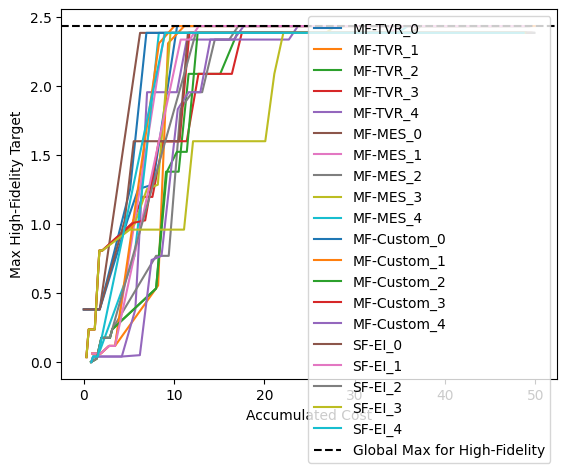

In [20]:
# This is code to debug the batch process a few cells later, showing the different runs individually, rather than averaged.
def plot_cost_batch_individual(domain, dictionary): 
    max_in_space= np.max(domain[np.where(domain[:, -2] == 1.0)])
    for search_alg in dictionary:
        train_x_full, train_obj, cumulative_cost = dictionary[search_alg]
        for j in range(len(train_x_full)):
            cumulative_cost_array = np.array(cumulative_cost[j])
            hf_indices = np.where(train_x_full[j][:, -1]==1.0)
            high_fidelity_obj = train_obj[j][np.where(train_x_full[j][:, -1]==1.0)].detach().numpy()
            accum_target = []
            for i in range(len(high_fidelity_obj)):
                accum_target.append(max(high_fidelity_obj[0:i+1]))

            plt.plot(cumulative_cost_array[hf_indices ], accum_target, label=f"{search_alg}_{j}")    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Target')
    plt.legend()

# new_dict = {'MF-MES': searchDictBatch['MF-MES']}    
plot_cost_batch_individual(domain, searchDictBatch)

In [21]:
# Helper Function for Batch Case. This takes the cumulative cost array, extracts the high-fidelity targets, calculates the maximum up-to-that-stage
# and then spreads it out evenly over an  assigned range of regular intervals (of cumulative cost).
# i.e. the cost_range_input, so that we can compare different runs/experiments and compute an average.
# For example, if we have accumulated cost of [1, 1.5, 2, 2.5, 3.5] with targets [2.1, 0.9, 3.5, 2.3, 5].
# This should give an output over:
# [1,   1.5, 2,   2.5,   3,   3.5, 4, 4.5, 5  ] - see, evenly spaced (which with MF isn't guaranteed)
# [2.1, 2.1, 3.5, 3.5,   3.5, 5,   5,   5,  5 ] - we only take the maximum hf target.

def discretise_cost_and_maximise(high_fidleity_points, cost_range_input, cumulative_cost_array_input, hf_indices_input):
    accum_target = []
    # This part generates the accumulated maximum of just each high-fidleity point so far.
    for i in range(len(high_fidleity_points)):
        accum_target.append(max(high_fidleity_points[0:i+1]))

    accum_target = np.array(accum_target)
    max_target = []
    #We mltiply by 100 to get past the floating poitn arithmetic errors when dealing with fidelities and intervals of 0.1, say.
    cumulative_cost_array_input_times_100 = np.array([int(x*100) for x in cumulative_cost_array_input])
    for id, x in enumerate(cost_range_input):
        if x in cumulative_cost_array_input_times_100[ hf_indices_input ]:
            max_target.append(accum_target[np.where(cumulative_cost_array_input_times_100[ hf_indices_input ] == x )[0]][0].item())
        elif id == 0:
            max_target.append(0)
        else:
            max_target.append(max_target[id-1])
    return max_target
#Unit-test:
print(discretise_cost_and_maximise( [2.1, 0.9, 3.5, 2.3, 5], [100,   150, 200,   250,   300,   350, 400, 450, 500  ] , np.array([1, 1.5, 2, 2.5, 3.5]), [0,1,2,3,4]))

[2.1, 2.1, 3.5, 3.5, 3.5, 5.0, 5.0, 5.0, 5.0]


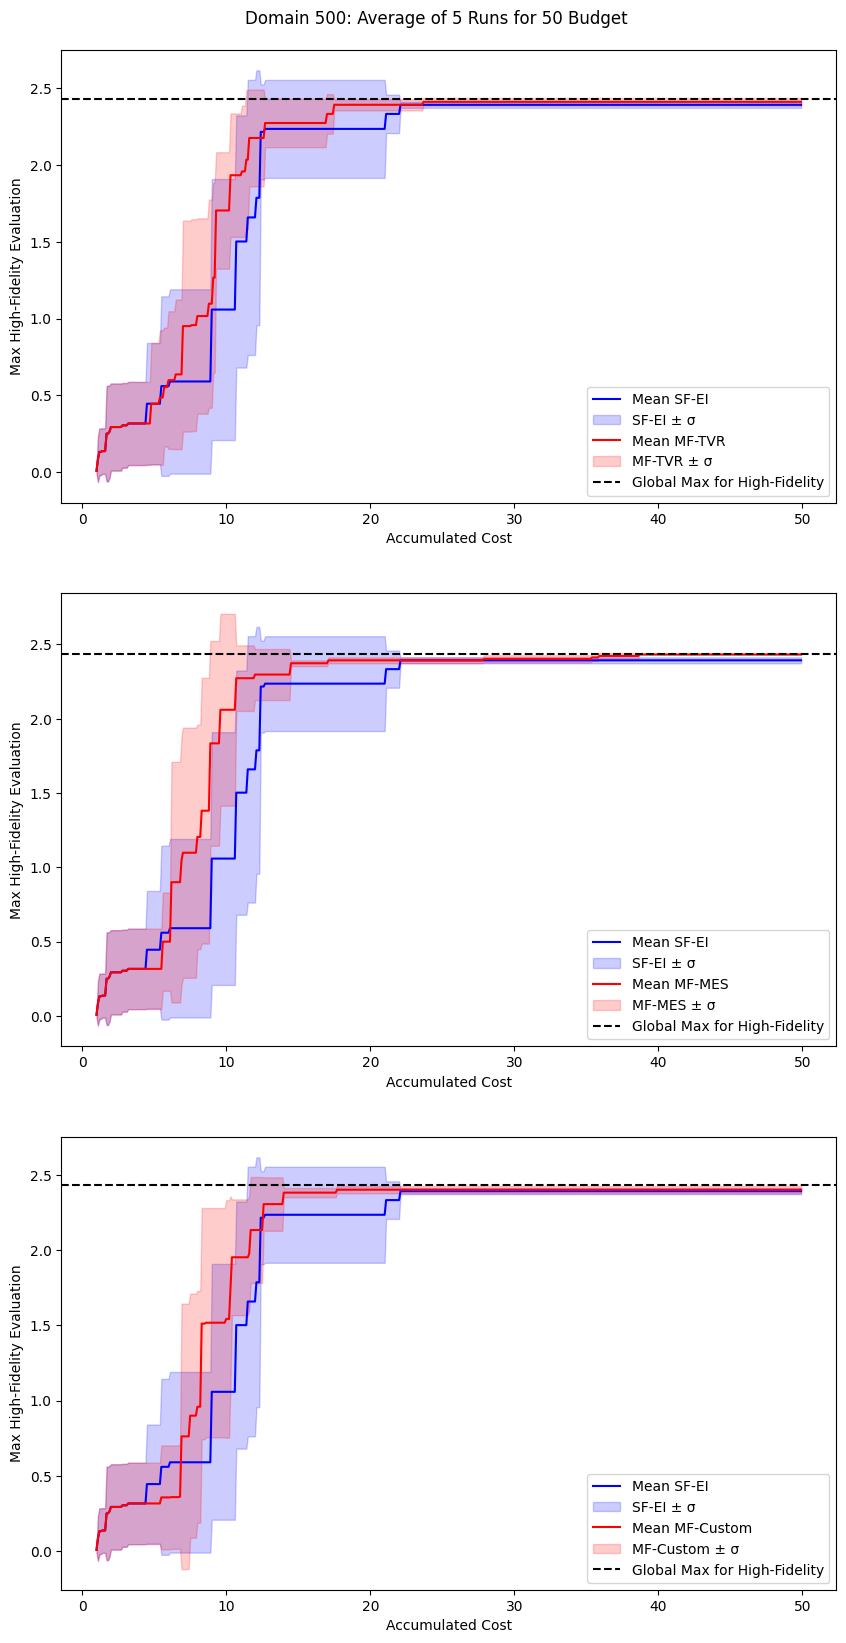

In [23]:
# Here we plot the mean maximum high-fidelity target reached so far with SD for a batch of experiments. 
def plot_cost_batch(domain, dictionary, title, allocated_budget, lf = 0.1, colour=['blue', 'red', 'green', 'yellow', 'orange']): 
    max_in_space= np.max(domain[np.where(domain[:, -2] == 1.0)])
    for id, search_alg in enumerate(dictionary):
        aggregate_max_target = []
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        
        #We mltiply by 100 to get past the floating poitn arithmetic errors when dealing with fidelities and intervals of 0.1, say.
        cost_range = list(np.arange(1* 100,allocated_budget*100, int(lf*100)))
        
        for batch_no in range(len(train_x_full_batch)):
            cumulative_cost_array = np.array([round(x,1) for x in cumulative_cost_batch[batch_no]])
            hf_indices = np.where(train_x_full_batch[batch_no][:, -1]==1.0)
            high_fidelity_obj = train_obj_batch[batch_no][np.where(train_x_full_batch[batch_no][:, -1]==1.0)].detach().numpy().squeeze(-1)
            max_target = discretise_cost_and_maximise(high_fidelity_obj, cost_range, cumulative_cost_array, hf_indices)
            aggregate_max_target.append(max_target)
        
        maximum_aggregate_mean = np.mean(aggregate_max_target, axis = 0)
        maximum_aggregate_lowerbound = maximum_aggregate_mean - np.std(aggregate_max_target, axis = 0)
        maximum_aggregate_upperbound = maximum_aggregate_mean + np.std(aggregate_max_target, axis = 0)

        cost_range_scaled = [x/100 for x in cost_range]
        plt.plot(cost_range_scaled, maximum_aggregate_mean, label=f'Mean {search_alg}', color=colour[id])
        plt.fill_between(x=cost_range_scaled, y1=maximum_aggregate_lowerbound, y2=maximum_aggregate_upperbound, color=colour[id], alpha=0.2, label=f'{search_alg} \xb1 \u03C3')    
    plt.axhline(y=max_in_space, color='black', linestyle='--', label='Global Max for High-Fidelity')
    plt.xlabel('Accumulated Cost')
    plt.ylabel('Max High-Fidelity Evaluation')
    plt.title(title)
    plt.legend(loc='lower right')

# plot_cost_batch(domain, searchDictBatch, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH, lf=0.1 )
def plot_pairwise(domain, searchDictBatch, main_key, lf, allocated_budget, no_of_expts ):
    keys_without = [x for x in searchDictBatch.keys()]
    keys_without.remove(main_key)
    no_of_rows = len(keys_without)
    figure=plt.figure(figsize=(10,20))
    for id, key in enumerate(keys_without):
        new_dict = {main_key: searchDictBatch[main_key], key: searchDictBatch[key]}
        plt.subplot(no_of_rows,1, id+1)
        plot_cost_batch(domain, 
                        new_dict,
                        title='', 
                        allocated_budget=ALLOCATED_BUDGET_BATCH, 
                        lf=lf)
    plt.suptitle(f'Domain {int(len(domain)/2)}: Average of {no_of_expts} Runs for {allocated_budget} Budget', y=0.9)
    save_image(figure)
    plt.show()

plot_pairwise(domain, searchDictBatch, main_key='SF-EI', lf=0.1, allocated_budget=ALLOCATED_BUDGET_BATCH, no_of_expts= N_EXP_BATCH)
# plot_cost_batch(domain, searchDictBatch, allocated_budget=ALLOCATED_BUDGET_BATCH, title='Test')

## Instantaneous and Cumulative Regret

In [29]:
# Instantaneous Regret and Cumulative Regret.
# We focus only on the high-fidelity points.
def discretise_evenly_for_averaging(stepwise_objective_points, cost_range_input, cumulative_cost_array_input, hf_evaluations):
    obj_target = []
    hf_evaluations_stretched = []
    #We multiply by 100 to get past the floating point arithmetic errors when dealing with fidelities and intervals of 0.1, say.
    # In this code we take the list of target evaluations which have already been "smoothed" across the x_train and "smooth" it
    # further across the cost_range. The cost_range is the more granular interval we are creating so that we can compare different
    # search-algorithsm, or different iterations of the same search-algorithm.
    # We also "smooth" out the hf_evaluations - this is a tally of the number of hf-evaluations so for over the cost_range_input.

    cumulative_cost_array_input_times_100 = np.array([int(x*100) for x in cumulative_cost_array_input])
    for id, x in enumerate(cost_range_input):
        if x in cumulative_cost_array_input_times_100:
            obj_target.append(stepwise_objective_points[np.where(cumulative_cost_array_input_times_100 == x )[0]][0].item())
            hf_evaluations_stretched.append(hf_evaluations[np.where(cumulative_cost_array_input_times_100 == x )[0]][0].item())
        elif id == 0:
            obj_target.append(0)
            hf_evaluations_stretched.append(1)
        else:
            obj_target.append(obj_target[id-1])
            hf_evaluations_stretched.append(hf_evaluations_stretched[id-1])
    return obj_target, hf_evaluations_stretched

def create_cumulative_regret(domain, train_x_batch, train_obj_batch, cumulative_cost_batch, cost_range, cum=True):
    max_in_space = np.max(domain[np.where(domain[:, -2] == 1.0)])
    aggregate_regret = []
    for batch_no in range(len(train_x_batch)):
            cumulative_cost_array = np.array(cumulative_cost_batch[batch_no])
            obj_modified = []
            # Since we want to compute the cumulative cost per high-fidelity evaluation, we need to
            # get some sort of list of the number of high-fidelity evaluations so far and when it's a lf call we keep the hf constant.
            # For example, [hf,lf,lf,hf,lf, hf, hf] = [1,1,1,2,2, 3, 4]
            hf_cum= []
            hf_count = 0
            for i in range(len(train_obj_batch[batch_no])):
                if train_x_batch[batch_no][i, -1]==1.0:
                    hf_count+=1
                    obj_modified.append(train_obj_batch[batch_no][i].item())
                    hf_cum.append(hf_count)
                else:
                    # If low-fidelity point, just take last high-fidelity point.
                    candidate = 0 if i ==0 else obj_modified[-1]
                    obj_modified.append(candidate)
                    hf_cum.append(hf_count)
            obj_modified = np.array(obj_modified)
            hf_cum= np.array(hf_cum)
            even_obj_over_range, hf_cum_stretched_out_over_range = discretise_evenly_for_averaging(obj_modified, cost_range, 
                                                                                                   cumulative_cost_array, 
                                                                                                   hf_cum)
            
            instantaneous_regret_per_hf_evaluation = (max_in_space - even_obj_over_range) / hf_cum_stretched_out_over_range

            cumulative_regret = [sum(instantaneous_regret_per_hf_evaluation[: i + 1]) for i in range(len(instantaneous_regret_per_hf_evaluation))]
            # cumulative_regret_per_hf_evaluation = cumulative_regret / hf_cum_stretched_out_over_range
            regret = cumulative_regret if cum else instantaneous_regret_per_hf_evaluation
            aggregate_regret.append(regret)
            
    aggregate_regret_mean = np.mean(aggregate_regret, axis = 0)
    aggregate_regret_lowerbound = aggregate_regret_mean - np.std(aggregate_regret, axis = 0)
    aggregate_regret_upperbound = aggregate_regret_mean + np.std(aggregate_regret, axis = 0)
    return aggregate_regret_mean, aggregate_regret_lowerbound, aggregate_regret_upperbound
            
def plot_instantaneous_and_cumulative_regret_batch(domain, dictionary, title, allocated_budget, cum=True, lf=0.5, colour=['blue', 'red', 'green', 'yellow']):
    # plt.figure(figsize=(16, 15))
    for id, search_alg in enumerate(dictionary):
        train_x_full_batch, train_obj_batch, cumulative_cost_batch = dictionary[search_alg]
        #We mltiply by 100 to get past the floating poitn arithmetic errors when dealing with fidelities and intervals of 0.1, say.
        cost_range = list(np.arange(1* 100, allocated_budget*100, int(lf*100)))
        aggregate_regret_mean, aggregate_regret_lowerbound, aggregate_regret_upperbound = create_cumulative_regret(domain, 
                                                                                                                   train_x_full_batch, 
                                                                                                                   train_obj_batch, 
                                                                                                                   cumulative_cost_batch, 
                                                                                                                   cost_range, 
                                                                                                                   cum)
        cost_range_scaled = [x/100 for x in cost_range]
        plt.plot(cost_range_scaled, aggregate_regret_mean, label=f'Mean {search_alg}', color=colour[id])
        plt.fill_between(x=cost_range_scaled, y1=aggregate_regret_lowerbound, y2=aggregate_regret_upperbound, color=colour[id], alpha=0.2, label=f'{search_alg} \xb1 \u03C3')    

    plt.xlabel('Accumulated Cost')
    plt.ylabel(f'{"Cumulative" if cum else "Instantaneous"} Regret per HF Evaluation')
    plt.title(title)
    plt.legend(loc='upper left')


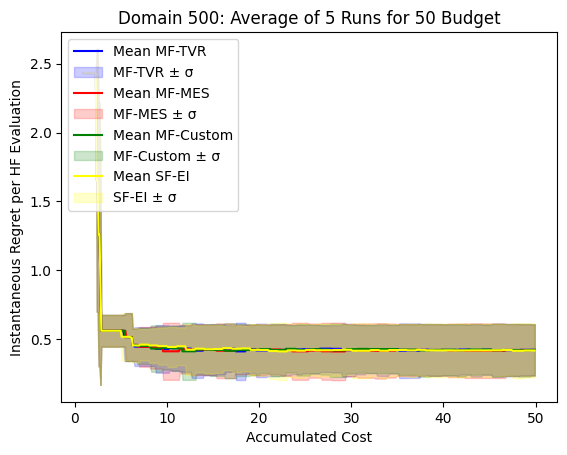

In [30]:
plot_instantaneous_and_cumulative_regret_batch(domain, searchDictBatch, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH, cum=False, lf=0.1 )

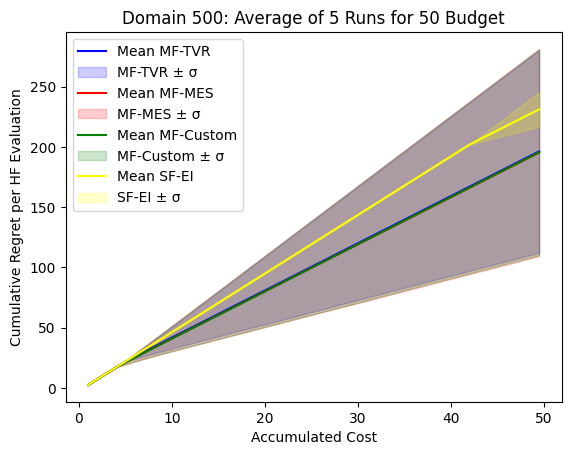

In [31]:
plot_instantaneous_and_cumulative_regret_batch(domain, searchDictBatch, f'Domain {int(len(domain)/2)}: Average of {N_EXP_BATCH} Runs for {ALLOCATED_BUDGET_BATCH} Budget', ALLOCATED_BUDGET_BATCH, cum=True )

# Fidelity and Correlation Heatmap

In [46]:
def build_cost_corr_dictionary(domain_size, variances=[300, 200,100,60,20], costs= [0.01, 0.1, 0.5, 0.9]):
    corr_dictionary = create_correlation_dict(domain_size, variances)
    corr_keys = [x for x in corr_dictionary.keys()]
    corr_keys.remove('base')
    cost_corr_dict = {}
    for key in corr_keys:
        cost_dict = {}
        for cost in costs:
            domain = []
            for j in range(len(corr_dictionary[key])):
                hf_point = np.append(corr_dictionary['base'][j], [1.0, corr_dictionary['1'][j]])
                lf_point= np.append(corr_dictionary['base'][j], [cost, corr_dictionary[key][j]])
                domain.append(hf_point)
                domain.append(lf_point)
            domain = np.array(domain)
            cost_dict[str(cost)]=domain
        cost_corr_dict[key] = cost_dict
    
    file_cost_corr_dict = save_dictionary(cost_corr_dict, root='HartmannCost_Corr_Dictionary')
    print(f'Produced Cost_corr dictionary is: {file_cost_corr_dict}')
    return cost_corr_dict, domain

In [16]:
N_EXP_BATCH = 1
INIT_SAMPLE_SIZE_BATCH=5
ALLOCATED_BUDGET_BATCH = 50

def build_batch_heat_map_cost_corr_dictionary(cost_corr_dictionary,
                                              domain, 
                                              batch_size=5, 
                                              init_sample_size=5, 
                                              budget=50,):

    # We need one domain defined (it doesn't matter what correlation) as when we generate batch sampel idnices we need to know the HF points 
    # to avoid calling in the initial sample. Recall, we avoid the top 5 percent.    
    predefined_indices = generate_batch_indices(domain)

    heat_map_dict={}
    for cor_key in cost_corr_dictionary.keys():
        cost_key_dict={}
        for cost_key in cost_corr_dictionary[cor_key].keys():
            train_x_full_ei_batch, train_obj_ei_batch, cumulative_cost_ei_batch, index_store_ei_batch = run_entire_cycle_batch(
                    batch_size,
                    cost_corr_dictionary[cor_key][cost_key],
                    init_sample_size, 
                    func=runEI,
                    allocated_budget = budget,
                    predefined_indices_batch = predefined_indices,
                    sf=True,
                    file=False
                    );
            train_x_full_custom_batch, train_obj_custom_batch, cumulative_cost_custom_batch, index_store_custom_batch = run_entire_cycle_batch(
                    batch_size,
                    cost_corr_dictionary[cor_key][cost_key],
                    init_sample_size, 
                    func=runCustom,
                    allocated_budget = budget,
                    predefined_indices_batch = predefined_indices,
                    file=False
                    );
            train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch, index_store_mes_batch = run_entire_cycle_batch(
                    batch_size,
                    cost_corr_dictionary[cor_key][cost_key],
                    init_sample_size, 
                    func=runMes,
                    allocated_budget = budget,
                    predefined_indices_batch = predefined_indices,
                    file=False
                    );
            train_x_full_tvr_batch, train_obj_tvr_batch, cumulative_cost_tvr_batch, index_store_tvr_batch = run_entire_cycle_batch(
                    batch_size,
                    cost_corr_dictionary[cor_key][cost_key],
                    init_sample_size, 
                    func=runTVR,
                    allocated_budget = budget,
                    predefined_indices_batch = predefined_indices,
                    file=False
                    );
            cost_key_dict[cost_key]  = {
                                        "MF-TVR": (train_x_full_tvr_batch, train_obj_tvr_batch, cumulative_cost_tvr_batch),
                                        "MF-MES": (train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch),
                                        "MF-Custom": (train_x_full_custom_batch, train_obj_custom_batch, cumulative_cost_custom_batch),
                                        "SF-EI": (train_x_full_ei_batch, train_obj_ei_batch, cumulative_cost_ei_batch)
                                          }
        heat_map_dict[cor_key]= cost_key_dict
    file_name = save_dictionary(heat_map_dict, root='HartmannHeatMapDictionaries')
    print(f'Produced heatmap is: {file_name}')
    return heat_map_dict
            

In [45]:
DOMAIN_SIZE=500
output_cost_corr_dict, domain = build_cost_corr_dictionary(DOMAIN_SIZE)
output_cost_corr_dict.keys()
heat_map_dictionary = build_batch_heat_map_cost_corr_dictionary(output_cost_corr_dict,
                                              domain, 
                                              batch_size=N_EXP_BATCH, 
                                              init_sample_size=INIT_SAMPLE_SIZE_BATCH, 
                                              budget=ALLOCATED_BUDGET_BATCH)


Produced Cost_corr dictionary is: HartmannCost_Corr_Dictionary/20240705-102759


dict_keys(['1', '0.920454935835308', '0.8467464126079256', '0.6378760331189262', '0.4633812660364092', '0.21258593948908508'])

In [41]:
def print_heat_map(heat_map_dictionary, cost_cor_dictionary, search_alg, axes, number_of_exp = 5, allocated_budget = 50):
    heat_map_scores_frame = pd.DataFrame()
    heat_map_per_cor_means = []
    costs = [0.01, 0.1, 0.5, 0.9]
    for cor_key in heat_map_dictionary.keys():
        heat_map_per_cost_means = []
        for cost_key in heat_map_dictionary[cor_key].keys():
            # costs = []
            # costs.append(cost_key)
            batch_scores = []
            domain = cost_cor_dictionary[cor_key][cost_key]
            train_x_full_mes_batch, train_obj_mes_batch, cumulative_cost_mes_batch = heat_map_dictionary[cor_key][cost_key][search_alg]
            max_domain_value = np.max(domain[np.where(domain[:, -2]==1.0)])
            for batch_no in range(number_of_exp):
                budget_when_reached = allocated_budget + 10
                if max_domain_value in train_obj_mes_batch[batch_no]:
                    index_max_reached = train_obj_mes_batch[batch_no].tolist().index(max_domain_value)
                    budget_when_reached = cumulative_cost_mes_batch[batch_no][index_max_reached]
                batch_scores.append(budget_when_reached)
            heat_map_per_cost_means.append(np.mean(batch_scores))
        heat_map_per_cor_means.append(heat_map_per_cost_means)

    heat_map_scores_frame = pd.DataFrame(heat_map_per_cor_means,
                                        columns=costs, 
                                        index=[round(float(x), 3) for x in heat_map_dictionary.keys()]).sort_index(axis=0, ascending=False)
    s = sns.heatmap(ax = axes, data = heat_map_scores_frame, cmap="crest")
    s.set_xlabel('Fidelity Cost', axes=axes)
    s.set_ylabel('Correlation', axes=axes)
    s.set_title(f'Heatmap for {search_alg}', axes=axes)


In [42]:
# heat_map_dictionary = load_dictionary('HartmannHeatMapDictionaries/20240705-102324')
# cost_corr_dictionary = load_dictionary('HartmannCost_Corr_Dictionary/20240705-094650')
# print(heat_map_dictionary.keys())
# print(cost_corr_dictionary.keys())

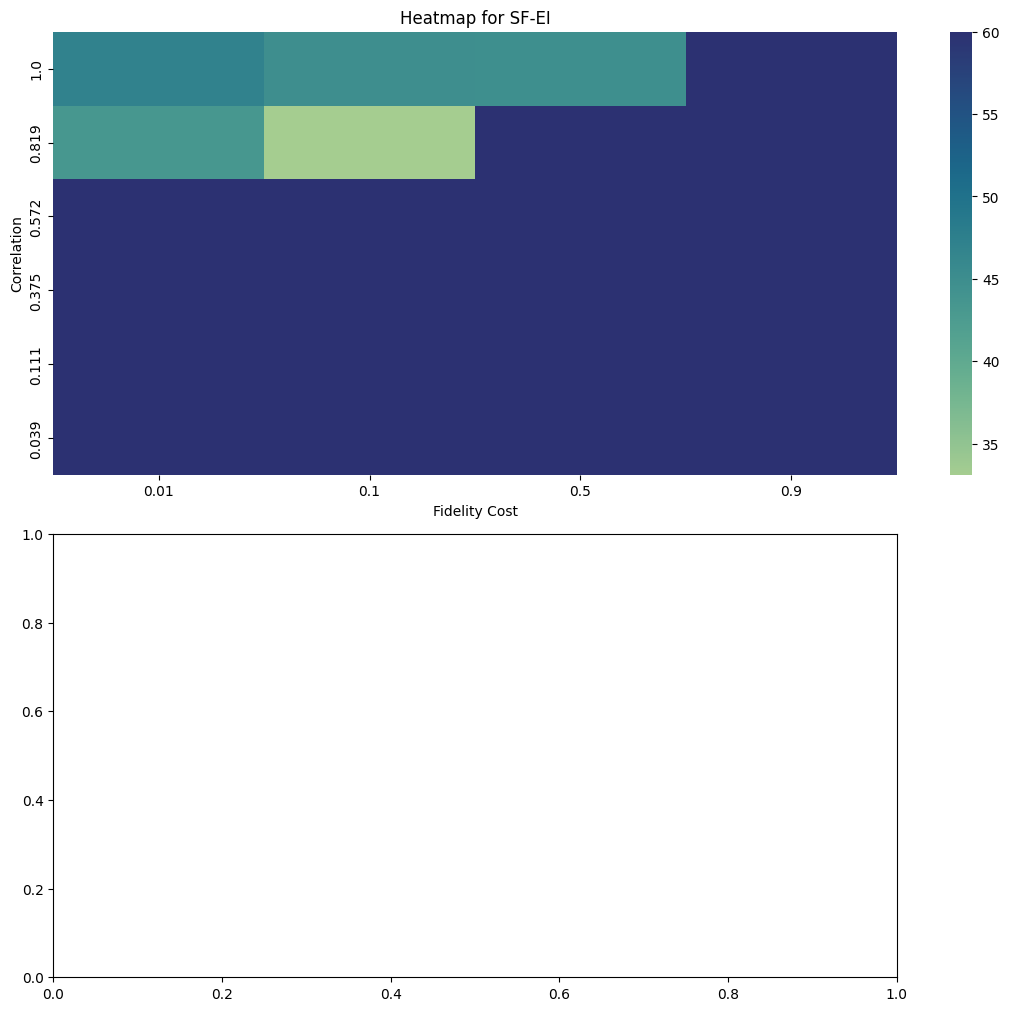

In [43]:
# heat_map_dictionary = load_dictionary('HartmannHeatMapDictionaries/20240705-095500')
fig, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True)
for index, search_alg in enumerate(['SF-EI']) :
    print_heat_map(heat_map_dictionary, output_cost_corr_dict, search_alg, axes[index], number_of_exp=N_EXP_BATCH, allocated_budget=ALLOCATED_BUDGET_BATCH)
    plt.subplot(2, 1, index + 1)
# fig.tight_layout(pad=0.5)

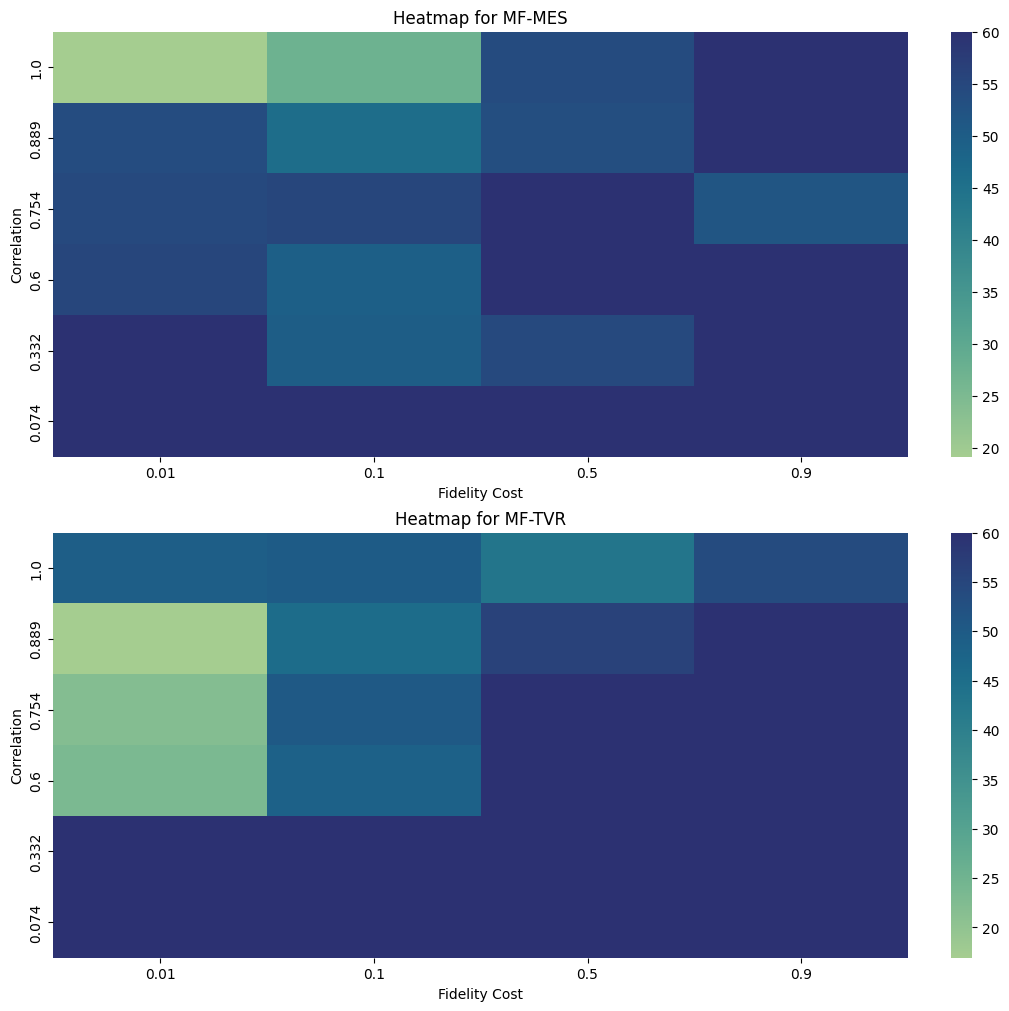

In [24]:
heat_map_dictionary = load_dictionary('HeatMapDictionaries/20240702-000632')
cost_cor_dictionary = load_dictionary('Cost_Corr_Dictionary/20240701-194436')
fig, axes = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True)
for index, search_alg in enumerate(['MF-MES', 'MF-TVR']) :
    print_heat_map(heat_map_dictionary, cost_cor_dictionary, search_alg, axes[index])
    # plt.subplot(2, 1, index + 1)
figure.tight_layout(pad=0.5)
plt.show()
